# **Dataset context**

The Garbage Classification dataset was created to support the development of machine learning models for automated waste sorting and recycling systems. It consists of labeled images of various types of garbage, such as cardboard, glass, metal, paper, plastic and general trash. The goal is to train models to recognize and classify these waste types based on visual characteristics.

This dataset is particularly useful for computer vision applications in environmental sustainability, where automatic identification of recyclable materials can aid in improving waste management efficiency, reducing human error and supporting smart bin technologies. Its real-world variability—such as different lighting, angles, and backgrounds—makes it suitable for building robust image classification systems.

# **Dataset content**

* **Total Classes**: 6 categories of garbage:

 - 1. cardboard

 - 2. glass

 - 3. metal

 - 4. paper

 - 5. plastic

 - 6. trash

* **File Format**: Images are stored as .jpg files. Typical image dimensions vary (e.g., ~384x512 pixels), but can be resized for modeling.

* **Labeling**: Each folder name serves as the class label for the images it contains.

* **Number of Images**: ~2,500–2,600 total images (approx. 400–500 per class).

* **Image Variety**: Photos include various object shapes, sizes, and backgrounds to mimic real-world conditions. Some images show used/dirty items, others are clean, making it suitable for generalization.

*(source: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification/data)*

# **Imports**

In [1]:
!pip install -r requirements.txt --quiet

In [2]:
# Standard Library Imports
import glob
import os
import zipfile
from typing import Dict, Union, List

# Data Manipulation & Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Utility & Interface
from IPython.display import display
import ipywidgets as widgets

# Image Processing
from PIL import Image
from skimage import io, transform

# Machine Learning & Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Deep Learning – Keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.layer_utils import count_params
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers

# Deep Learning – TensorFlow (Keras backend)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import Model, Input

# Deep Learning – PyTorch
import torch

# **Functions**

In [3]:
def handle_upload(change: dict) -> None:
    """
    Handles the upload event for Kaggle JSON credential file.
    """
    if uploader.value:
        for fname, file in uploader.value.items():
            # Save the file temporarily
            with open("kaggle.json", "wb") as f:
                f.write(file["content"])
                print("kaggle.json saved locally.")
                
        # Create the .kaggle directory if it doesn't exist
        kaggle_dir = os.path.expanduser("~/.kaggle")
        os.makedirs(kaggle_dir, exist_ok=True)
        # Move the file to ~/.kaggle
        os.replace("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
        print("kaggle.json moved to ~/.kaggle")

In [4]:
def load_and_inspect_dataset(set_path: str, label_map: Dict[int, str])-> pd.DataFrame:
    """
    Loads training data from a CSV file, inspects its structure, maps numeric labels to class names,
    and prints summary information.
    """
    # Read the train data
    df = pd.read_csv(set_path, header=None, names=['picture', 'label'], delimiter=" ")

    # Display top 5 rows
    print("First 5 rows of the dataset:")
    print(df.head())

    # Check for missing values
    print("\n\nMissing values in each column:")
    print(df.isnull().sum())

    # Map label integers to class names
    df['label_name'] = df['label'].map(label_map)

    # Display dataset size
    print(f"\n\nTotal number of training examples: {len(df)}")

    # Show class distribution
    print("\n\nLabel distribution:")
    print(df['label'].value_counts())

    # Show info about DataFrame
    print("\n\nDataFrame info:")
    df.info()

    return df

In [5]:
def plot_label_distribution(df: pd.DataFrame) -> None:
    """
    Generates and displays a count plot for label distribution in the given DataFrame.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='label_name', order=df['label_name'].value_counts().index)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Label Distribution in train_df')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
def display_sample_images(df: pd.DataFrame, data_dir: Union[str, os.PathLike]) -> None:
    """
    Displays one sample image per class from the training dataset with class labels.
    """
    classes = df['label_name'].unique()
    for label in classes:
        # Get the first sample image for the label
        sample = df[df['label_name'] == label].iloc[0]
        img_path = os.path.join(data_dir, sample['label_name'], str(sample['picture']))
        
        try:
            img = Image.open(img_path)
            plt.figure()
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
        except FileNotFoundError:
            print(f"Image file not found: {img_path}")

In [7]:
def evaluate_model(trained_model: Sequential) -> None:
    """
    Visualizes the training and validation accuracy and loss over epochs from a trained Keras model.
    """
    accuracy = trained_model.history.history['accuracy']
    val_accuracy = trained_model.history.history['val_accuracy']
    loss = trained_model.history.history['loss']
    val_loss = trained_model.history.history['val_loss']
    epochs = range(len(accuracy))
    
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [8]:
def plot_confusion_matrix(model: Sequential, test_iterator) -> None:
    """
    Generates and displays a visually enhanced confusion matrix for a given model's predictions.
    """
    y_true = test_iterator.classes
    y_pred_probs = model.predict(test_iterator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    labels = [label for label, index in sorted(test_iterator.class_indices.items(), key=lambda x: x[1])]
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=False)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [9]:
def generate_confusion_matrix_and_classification_report(model: Sequential, test_iterator) -> None:
    """
    Computes and returns the confusion matrix for a given model and test data iterator.
    """
    # Ensure consistent results by resetting the iterator
    test_iterator.reset()

    # Ground truth labels
    y_true = test_iterator.classes

    # Model predictions
    y_pred_probs = model.predict(test_iterator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Display label mapping
    sorted_labels = [label for label, index in sorted(test_iterator.class_indices.items(), key=lambda x: x[1])]
    print("Label order:", sorted_labels)

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

In [10]:
def save_model_performance(name: str,
                           test_acc: List[float],
                           test_loss: List[float],
                           train_params: List[int],
                           non_train_params: List[int],
                           model: Model,
                           test_eval: List[float]) -> None:
    """
    Appends performance metrics and parameter counts of a model to tracking lists.
    """
    model_name.append(name)
    test_acc.append(test_eval[1])
    test_loss.append(test_eval[0])
    train_params.append(count_params(model.trainable_weights))
    non_train_params.append(count_params(model.non_trainable_weights))

In [11]:
def predict_image(model, img_path, class_labels) -> str:
    """
    Predicts the class of an input image using a trained MobileNetV2 model.
    """

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_index]

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

    return predicted_label

# **Data preparation and downloading**

In [12]:
# Upload kaggle.json
uploader = widgets.FileUpload(accept='.json', multiple=False)
display(uploader)

FileUpload(value={}, accept='.json', description='Upload')

kaggle.json saved locally.
kaggle.json moved to ~/.kaggle


In [13]:
# Attach the handler to the uploader
uploader.observe(handle_upload, names='value')

In [14]:
# Download dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
# Unzip the data
with zipfile.ZipFile("garbage-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_dataset")

In [16]:
# The data consists of 5 text files
for root, dirs, files in os.walk("garbage_dataset"):
    print(f"Directory: {root}")
    print(f"Files: {files[:5]}")
    break

Directory: garbage_dataset
Files: ['one-indexed-files-notrash_test.txt', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'one-indexed-files.txt', 'zero-indexed-files.txt']


# EDA

In [17]:
# There are 6 labels of garbage: cardboard, glass, metal, paper, plastic and trash
data_dir  = './garbage_dataset/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [18]:
# Define train, test and val sets paths
train_dir = './garbage_dataset/one-indexed-files-notrash_train.txt'
test_dir = './garbage_dataset/one-indexed-files-notrash_test.txt'
val_dir = './garbage_dataset/one-indexed-files-notrash_val.txt'

In [19]:
# Map the labels of data to put them on the plots
label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

## **Train set**

In [20]:
# There are no missing values
# Total number of examples for train set is 1768
train_df = load_and_inspect_dataset(train_dir, label_map)

First 5 rows of the dataset:
            picture  label
0  cardboard202.jpg      3
1      paper472.jpg      2
2      paper522.jpg      2
3      glass189.jpg      1
4      glass325.jpg      1


Missing values in each column:
picture    0
label      0
dtype: int64


Total number of training examples: 1768


Label distribution:
2    403
1    354
4    347
3    287
5    286
6     91
Name: label, dtype: int64


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     1768 non-null   object
 1   label       1768 non-null   int64 
 2   label_name  1768 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.6+ KB


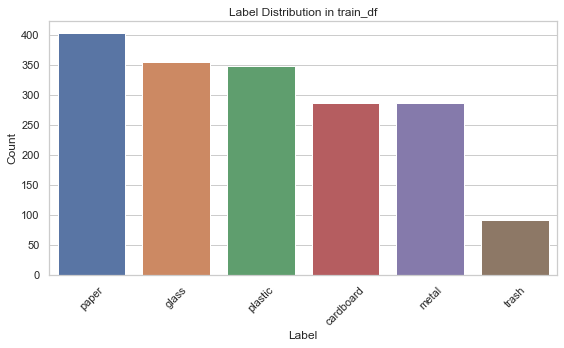

In [21]:
# There are the most glass examples (403) and the least trash examples (91)
plot_label_distribution(train_df)

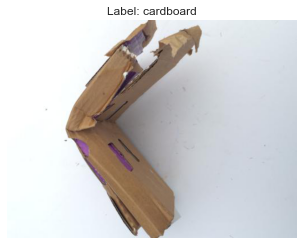

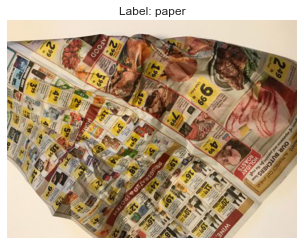

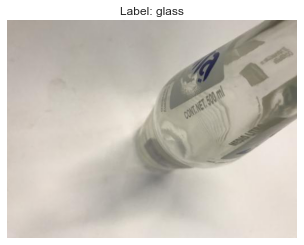

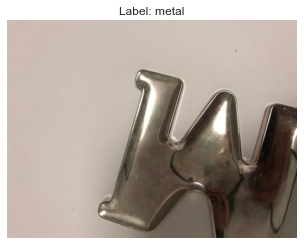

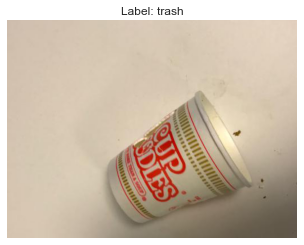

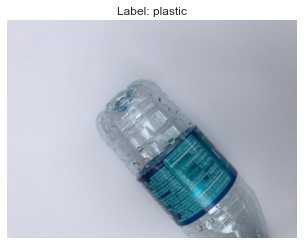

In [22]:
# Display sample images per class for train set
display_sample_images(train_df, data_dir)

## **Test set**

In [23]:
# There are no missing values
# Total number of examples for train set is 431
test_df = load_and_inspect_dataset(test_dir, label_map)

First 5 rows of the dataset:
           picture  label
0      paper70.jpg      2
1     paper380.jpg      2
2  cardboard31.jpg      3
3      glass12.jpg      1
4     paper169.jpg      2


Missing values in each column:
picture    0
label      0
dtype: int64


Total number of training examples: 431


Label distribution:
2    108
1     82
4     74
3     70
5     68
6     29
Name: label, dtype: int64


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     431 non-null    object
 1   label       431 non-null    int64 
 2   label_name  431 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.2+ KB


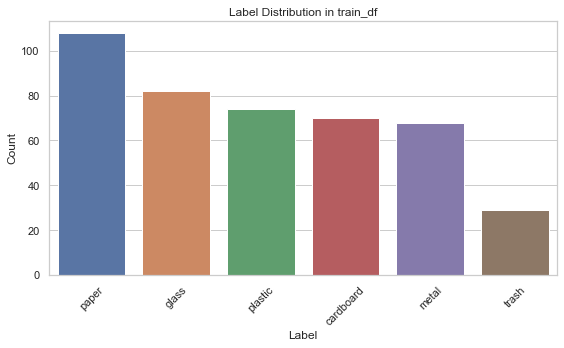

In [24]:
# There are the most glass examples (108) and the least trash examples (29)
plot_label_distribution(test_df)

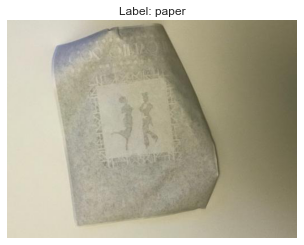

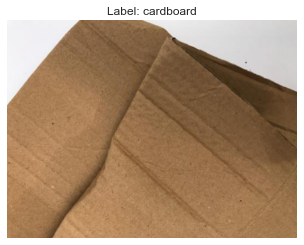

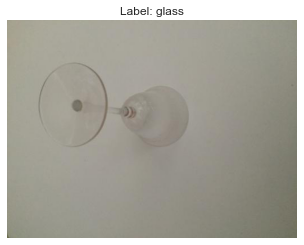

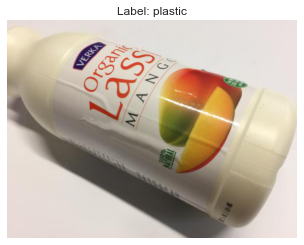

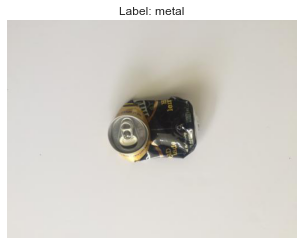

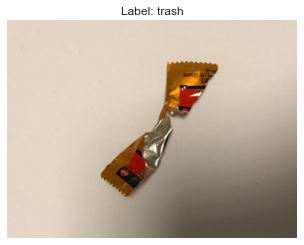

In [25]:
# Display sample images per class for test set
display_sample_images(test_df, data_dir)

## **Validation set**

In [26]:
# There are no missing values
# Total number of examples for train set is 328
val_df = load_and_inspect_dataset(val_dir, label_map)

First 5 rows of the dataset:
            picture  label
0  cardboard114.jpg      3
1    plastic204.jpg      4
2      glass123.jpg      1
3      glass152.jpg      1
4      glass398.jpg      1


Missing values in each column:
picture    0
label      0
dtype: int64


Total number of training examples: 328


Label distribution:
2    83
1    65
4    61
5    56
3    46
6    17
Name: label, dtype: int64


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     328 non-null    object
 1   label       328 non-null    int64 
 2   label_name  328 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.8+ KB


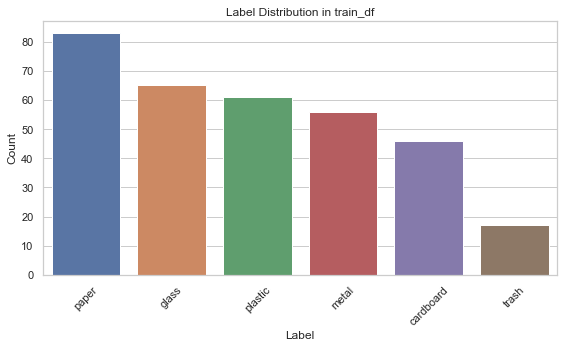

In [27]:
# There are the most glass examples (83) and the least trash examples (17)
plot_label_distribution(val_df)

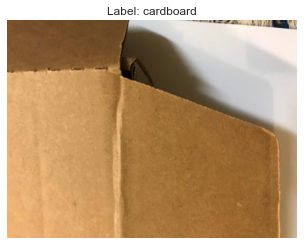

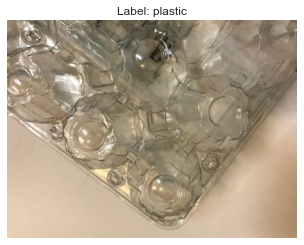

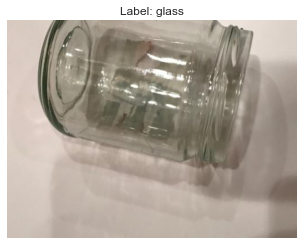

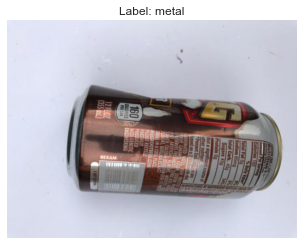

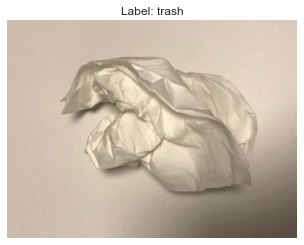

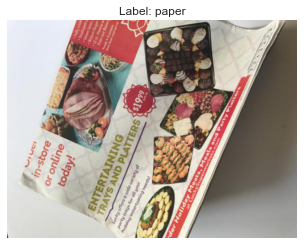

In [28]:
# Display sample images per class for test set
display_sample_images(val_df, data_dir)

# Generators and iterators for each set

In [29]:
# Define relative paths for all sets
train_df['rel_path'] = train_df['label_name']+'/'+train_df['picture']
test_df['rel_path'] = test_df['label_name']+'/'+test_df['picture']
val_df['rel_path'] = val_df['label_name']+'/'+val_df['picture']

In [30]:
# Generators
train_generator = ImageDataGenerator(rescale = 1./255)
val_generator = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

In [31]:
# Iterators
train_iterator = train_generator.flow_from_dataframe(train_df,
                                                     directory = data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical',
                                                    shuffle=False)

val_iterator = val_generator.flow_from_dataframe(val_df,
                                                 directory =  data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical',
                                                    shuffle=False)

test_iterator = test_generator.flow_from_dataframe(test_df,
                                                    directory = data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


# Models

In [32]:
# Gather results for each model
model_name = []
test_acc = []
test_loss = []
train_params = []
non_train_params = []

## Model 1

In [33]:
# Architecture (CNN with MaxPooling)
model_I = Sequential()

model_I.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(2, 2))

model_I.add(Flatten())
model_I.add(Dense(64, activation='relu'))
model_I.add(Dense(6, activation='softmax'))

In [34]:
# Model compilation
model_I.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
history = model_I.fit(train_iterator, epochs=10, validation_data=val_iterator, batch_size=128)

Epoch 1/10
4/4 [==============================] - 89s 17s/step - loss: 1.7549 - accuracy: 0.2296 - val_loss: 1.6986 - val_accuracy: 0.2530
Epoch 2/10
4/4 [==============================] - 30s 7s/step - loss: 1.7026 - accuracy: 0.2449 - val_loss: 1.6839 - val_accuracy: 0.2530
Epoch 3/10
4/4 [==============================] - 32s 7s/step - loss: 1.6811 - accuracy: 0.2359 - val_loss: 1.6659 - val_accuracy: 0.2774
Epoch 4/10
4/4 [==============================] - 31s 7s/step - loss: 1.6459 - accuracy: 0.2568 - val_loss: 1.6326 - val_accuracy: 0.2866
Epoch 5/10
4/4 [==============================] - 31s 9s/step - loss: 1.6062 - accuracy: 0.3179 - val_loss: 1.6079 - val_accuracy: 0.3293
Epoch 6/10
4/4 [==============================] - 32s 7s/step - loss: 1.5686 - accuracy: 0.3891 - val_loss: 1.5713 - val_accuracy: 0.3689
Epoch 7/10
4/4 [==============================] - 32s 7s/step - loss: 1.5185 - accuracy: 0.4118 - val_loss: 1.5311 - val_accuracy: 0.4146
Epoch 8/10
4/4 [=================

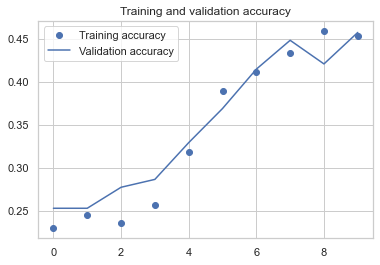

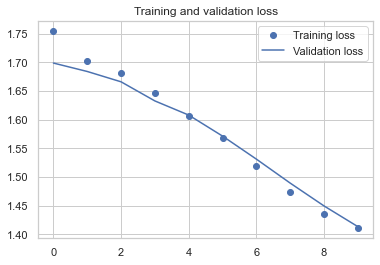

In [36]:
evaluate_model(model_I)

In [37]:
test_eval = model_I.evaluate(test_iterator, verbose=0)

In [38]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.418380618095398
Test accuracy: 0.4292343258857727


1/1 [==============================] - 4s 4s/step


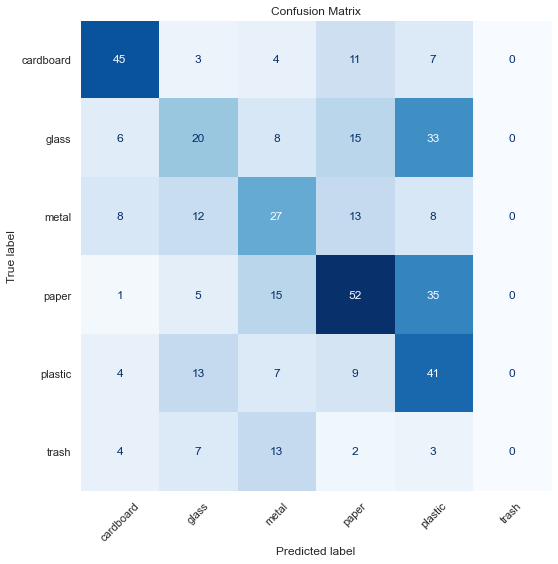

In [39]:
plot_confusion_matrix(model_I, test_iterator)

In [40]:
generate_confusion_matrix_and_classification_report(model_I, test_iterator)

1/1 [==============================] - 4s 4s/step
Label order: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Confusion Matrix:
 [[45  3  4 11  7  0]
 [ 6 20  8 15 33  0]
 [ 8 12 27 13  8  0]
 [ 1  5 15 52 35  0]
 [ 4 13  7  9 41  0]
 [ 4  7 13  2  3  0]]


In [41]:
# Save model performance
save_model_performance(name="Simple neural network",
                       test_acc=test_acc,
                       test_loss=test_loss,
                       train_params=train_params,
                       non_train_params=non_train_params,
                       model=model_I,
                       test_eval=test_eval)

* Training Accuracy improved from 22.96% to 45.36%.
* Validation Accuracy improved from 25.3% to 45.73%.
* Both training and validation loss consistently decreased, indicating that the model is learning well without overfitting.
* Most correct predictions appear on the diagonal (e.g., 52 for paper, 45 for cardboard).
* Paper is often misclassified as metal (15 times) and plastic (35 times).
* Plastic also gets confused with glass (13 times).
* Metal is frequently misclassified as paper (13 times).
* There are no examples of trach class.

## Model 2 (dropout)

In [42]:
model_II = Sequential()

model_II.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.2))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.2))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(2, 2))
model_II.add(Dropout(0.2))

model_II.add(Flatten())
model_II.add(Dense(64, activation='relu'))
model_II.add(Dense(6, activation='softmax'))

In [43]:
model_II.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [44]:
history_II = model_II.fit(train_iterator, epochs=10, validation_data=val_iterator, batch_size=128)

Epoch 1/10
4/4 [==============================] - 33s 7s/step - loss: 1.8300 - accuracy: 0.1776 - val_loss: 1.7555 - val_accuracy: 0.2530
Epoch 2/10
4/4 [==============================] - 31s 7s/step - loss: 1.7283 - accuracy: 0.2234 - val_loss: 1.7147 - val_accuracy: 0.2195
Epoch 3/10
4/4 [==============================] - 28s 6s/step - loss: 1.7224 - accuracy: 0.2268 - val_loss: 1.7125 - val_accuracy: 0.2530
Epoch 4/10
4/4 [==============================] - 27s 6s/step - loss: 1.7040 - accuracy: 0.2347 - val_loss: 1.7147 - val_accuracy: 0.2561
Epoch 5/10
4/4 [==============================] - 27s 6s/step - loss: 1.6830 - accuracy: 0.2472 - val_loss: 1.6894 - val_accuracy: 0.2927
Epoch 6/10
4/4 [==============================] - 26s 6s/step - loss: 1.6498 - accuracy: 0.2885 - val_loss: 1.6473 - val_accuracy: 0.3293
Epoch 7/10
4/4 [==============================] - 26s 6s/step - loss: 1.6102 - accuracy: 0.3286 - val_loss: 1.6157 - val_accuracy: 0.3598
Epoch 8/10
4/4 [==================

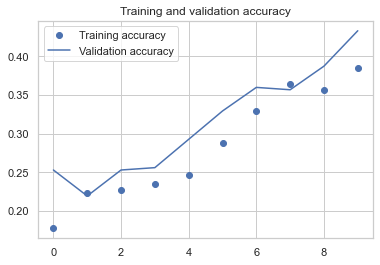

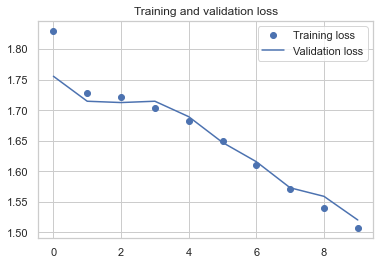

In [45]:
evaluate_model(model_II)

In [46]:
test_eval = model_II.evaluate(test_iterator, verbose=0)

In [47]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])   

Test loss: 1.5351366996765137
Test accuracy: 0.3781902492046356


1/1 [==============================] - 3s 3s/step


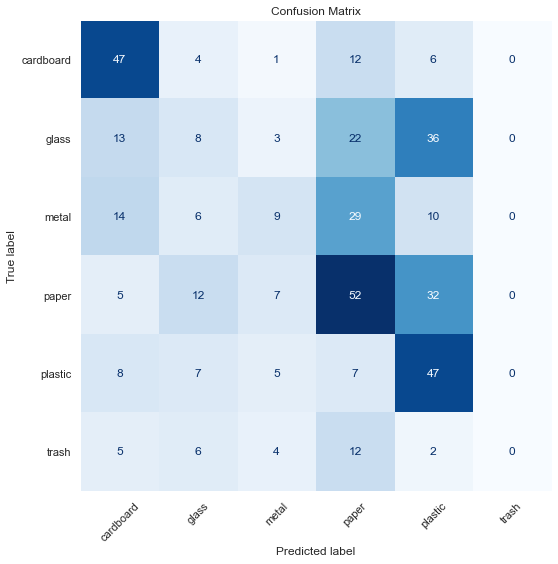

In [48]:
plot_confusion_matrix(model_II, test_iterator)

In [49]:
generate_confusion_matrix_and_classification_report(model_II, test_iterator)

1/1 [==============================] - 3s 3s/step
Label order: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Confusion Matrix:
 [[47  4  1 12  6  0]
 [13  8  3 22 36  0]
 [14  6  9 29 10  0]
 [ 5 12  7 52 32  0]
 [ 8  7  5  7 47  0]
 [ 5  6  4 12  2  0]]


In [50]:
# Save model performance
save_model_performance(name="Neural network with dropout",
                       test_acc=test_acc,
                       test_loss=test_loss,
                       train_params=train_params,
                       non_train_params=non_train_params,
                       model=model_II,
                       test_eval=test_eval)

* Training accuracy increased from 15.76% to 38.46%.

* Validation loss dropped from 1.7555 to 1.5205 (a reduction of 13.4%).

* Training and validation curves show steady learning with no major signs of overfitting.
* Glass class performance is weak: only 8/82 correctly predicted — accuracy ~9.75%.

* Trash class not detected at all: suggests feature overlap or lack of representation.
 
* Paper class is best-performing: 52/108 correct — accuracy ~48.15%.

* High confusion between paper, glass, plastic, and metal, which may share visual traits.

## Model 3 (normalization)

In [51]:
model_III = Sequential()

model_III.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.2))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.2))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(2, 2))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.2))

model_III.add(Flatten())
model_III.add(Dense(64, activation='relu'))
model_III.add(Dense(6, activation='softmax'))

In [52]:
model_III.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [53]:
history_III = model_III.fit(train_iterator, epochs=10, validation_data=val_iterator, batch_size=128)

Epoch 1/10
4/4 [==============================] - 29s 8s/step - loss: 1.9164 - accuracy: 0.2794 - val_loss: 1.7468 - val_accuracy: 0.2500
Epoch 2/10
4/4 [==============================] - 26s 6s/step - loss: 1.5133 - accuracy: 0.4508 - val_loss: 1.7511 - val_accuracy: 0.2530
Epoch 3/10
4/4 [==============================] - 28s 7s/step - loss: 1.4049 - accuracy: 0.4842 - val_loss: 1.7551 - val_accuracy: 0.2530
Epoch 4/10
4/4 [==============================] - 29s 8s/step - loss: 1.3346 - accuracy: 0.5158 - val_loss: 1.7616 - val_accuracy: 0.2530
Epoch 5/10
4/4 [==============================] - 31s 7s/step - loss: 1.2224 - accuracy: 0.5317 - val_loss: 1.7706 - val_accuracy: 0.2530
Epoch 6/10
4/4 [==============================] - 32s 7s/step - loss: 1.1664 - accuracy: 0.5532 - val_loss: 1.7579 - val_accuracy: 0.2530
Epoch 7/10
4/4 [==============================] - 30s 6s/step - loss: 1.1173 - accuracy: 0.5860 - val_loss: 1.7756 - val_accuracy: 0.2530
Epoch 8/10
4/4 [==================

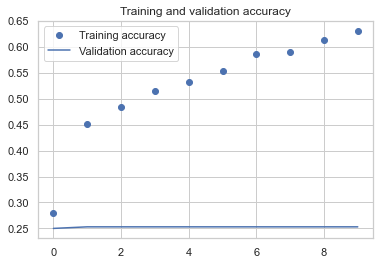

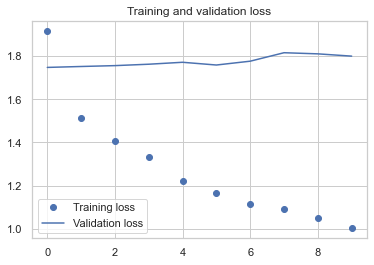

In [54]:
evaluate_model(model_III)

In [55]:
test_eval = model_III.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])    

Test loss: 1.8136447668075562
Test accuracy: 0.2505800426006317


1/1 [==============================] - 3s 3s/step


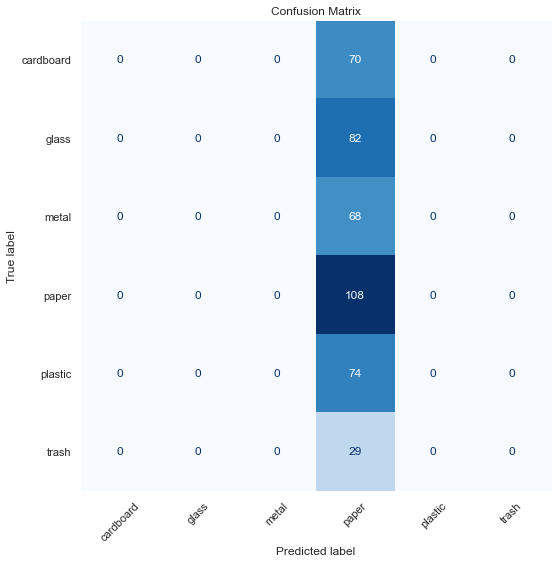

In [56]:
plot_confusion_matrix(model_III, test_iterator)

In [57]:
generate_confusion_matrix_and_classification_report(model_III, test_iterator)

1/1 [==============================] - 3s 3s/step
Label order: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Confusion Matrix:
 [[  0   0   0  70   0   0]
 [  0   0   0  82   0   0]
 [  0   0   0  68   0   0]
 [  0   0   0 108   0   0]
 [  0   0   0  74   0   0]
 [  0   0   0  29   0   0]]


In [58]:
# Save model performance
save_model_performance(name="Neural network with normalization",
                       test_acc=test_acc,
                       test_loss=test_loss,
                       train_params=train_params,
                       non_train_params=non_train_params,
                       model=model_III,
                       test_eval=test_eval)

* Training accuracy improved significantly: +35.18 % (from 27.94% to 63.12%).

* Validation accuracy remained flat at 25.3% across all epochs.

* Model optimized well on training data, but failed to generalize to validation or test sets.
* Performance mirrors validation scores — indicating strong overfitting.

* Only one class ("paper") was predicted - severe model bias or data leakage.

## Model 4

In [59]:
model_IV = Sequential()

model_IV.add(Conv2D(32, (5,5), kernel_regularizer=regularizers.L1L2(1e-5, 1e-4), 
                    kernel_initializer='glorot_uniform', activation='relu', input_shape=(128,128,3)))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.2))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(1e-5, 1e-4), 
                    kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.2))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(1e-5, 1e-4), 
                    kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(2, 2))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.2))

model_IV.add(Flatten())
model_IV.add(Dense(128, activation='relu'))
model_IV.add(Dropout(0.2))
model_IV.add(Dense(6, activation='softmax'))

In [60]:
# Model compilation
model_IV.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [61]:
history_IV = model_IV.fit(train_iterator, epochs=10, validation_data=val_iterator, batch_size=128)

Epoch 1/10
4/4 [==============================] - 29s 6s/step - loss: 2.2464 - accuracy: 0.2511 - val_loss: 1.7961 - val_accuracy: 0.2530
Epoch 2/10
4/4 [==============================] - 26s 6s/step - loss: 1.6102 - accuracy: 0.4480 - val_loss: 1.7816 - val_accuracy: 0.2530
Epoch 3/10
4/4 [==============================] - 31s 7s/step - loss: 1.5019 - accuracy: 0.4632 - val_loss: 1.7744 - val_accuracy: 0.2530
Epoch 4/10
4/4 [==============================] - 29s 6s/step - loss: 1.3911 - accuracy: 0.5040 - val_loss: 1.7682 - val_accuracy: 0.2561
Epoch 5/10
4/4 [==============================] - 30s 7s/step - loss: 1.3205 - accuracy: 0.5232 - val_loss: 1.7650 - val_accuracy: 0.2530
Epoch 6/10
4/4 [==============================] - 36s 9s/step - loss: 1.2940 - accuracy: 0.5283 - val_loss: 1.7668 - val_accuracy: 0.2530
Epoch 7/10
4/4 [==============================] - 35s 8s/step - loss: 1.2358 - accuracy: 0.5594 - val_loss: 1.7861 - val_accuracy: 0.2530
Epoch 8/10
4/4 [==================

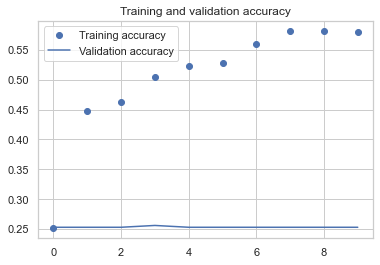

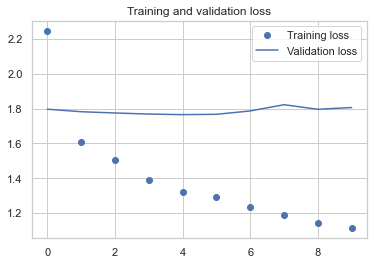

In [62]:
evaluate_model(model_IV)

In [63]:
test_eval = model_IV.evaluate(test_iterator, verbose=0)

In [64]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])  

Test loss: 1.8341727256774902
Test accuracy: 0.2505800426006317


1/1 [==============================] - 4s 4s/step


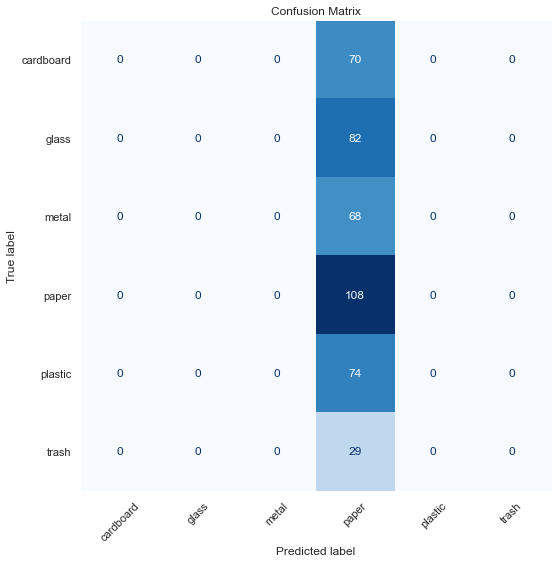

In [65]:
plot_confusion_matrix(model_IV, test_iterator)

In [66]:
generate_confusion_matrix_and_classification_report(model_IV, test_iterator)

1/1 [==============================] - 4s 4s/step
Label order: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Confusion Matrix:
 [[  0   0   0  70   0   0]
 [  0   0   0  82   0   0]
 [  0   0   0  68   0   0]
 [  0   0   0 108   0   0]
 [  0   0   0  74   0   0]
 [  0   0   0  29   0   0]]


In [67]:
# Save model performance
save_model_performance(name="Neural network with regularizers",
                       test_acc=test_acc,
                       test_loss=test_loss,
                       train_params=train_params,
                       non_train_params=non_train_params,
                       model=model_IV,
                       test_eval=test_eval)

* Training accuracy improved by 32.92 % (from 25.116% to 58.03%).

* Validation accuracy remained flat at 25.30% for all epochs.

* Loss reduction on training set shows learning — but no improvement on validation/test sets.
* Training-generalization gap persists - signs of severe overfitting.
* Only "paper" was predicted for all inputs — resulting in accuracy of 100% for paper and 0% for all other classes.

## Model 5 (MobileNet2)

In [68]:
input_tensor = Input(shape=(128, 128, 3))
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_tensor=input_tensor,
    weights='imagenet'
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(6, activation='softmax')(x)

model_V = Model(inputs=base_model.input, outputs=output_tensor)

In [69]:
# Model compilation
model_V.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history_V = model_V.fit(train_iterator, epochs=10, validation_data=val_iterator, batch_size=128)

Epoch 1/10
4/4 [==============================] - 41s 10s/step - loss: 1.7688 - accuracy: 0.3552 - val_loss: 1.3351 - val_accuracy: 0.5244
Epoch 2/10
4/4 [==============================] - 30s 7s/step - loss: 1.0898 - accuracy: 0.6363 - val_loss: 1.0617 - val_accuracy: 0.6311
Epoch 3/10
4/4 [==============================] - 30s 7s/step - loss: 0.7847 - accuracy: 0.7274 - val_loss: 0.8959 - val_accuracy: 0.6494
Epoch 4/10
4/4 [==============================] - 32s 8s/step - loss: 0.6205 - accuracy: 0.7800 - val_loss: 0.8631 - val_accuracy: 0.6799
Epoch 5/10
4/4 [==============================] - 32s 9s/step - loss: 0.5468 - accuracy: 0.8009 - val_loss: 0.7837 - val_accuracy: 0.7012
Epoch 6/10
4/4 [==============================] - 31s 7s/step - loss: 0.4663 - accuracy: 0.8405 - val_loss: 0.7616 - val_accuracy: 0.7287
Epoch 7/10
4/4 [==============================] - 30s 7s/step - loss: 0.4060 - accuracy: 0.8648 - val_loss: 0.7323 - val_accuracy: 0.7409
Epoch 8/10
4/4 [=================

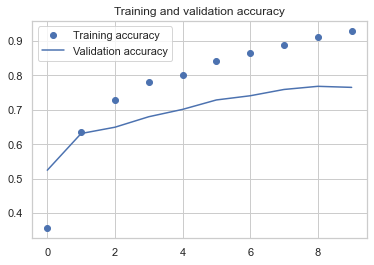

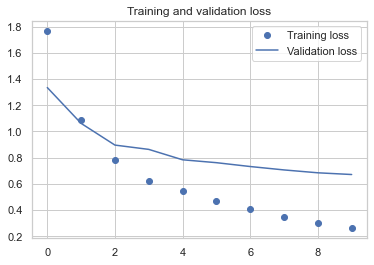

In [71]:
evaluate_model(model_V)

In [72]:
test_eval = model_V.evaluate(test_iterator, verbose=0)

In [73]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])  

Test loss: 0.6711963415145874
Test accuracy: 0.7726218104362488


1/1 [==============================] - 8s 8s/step


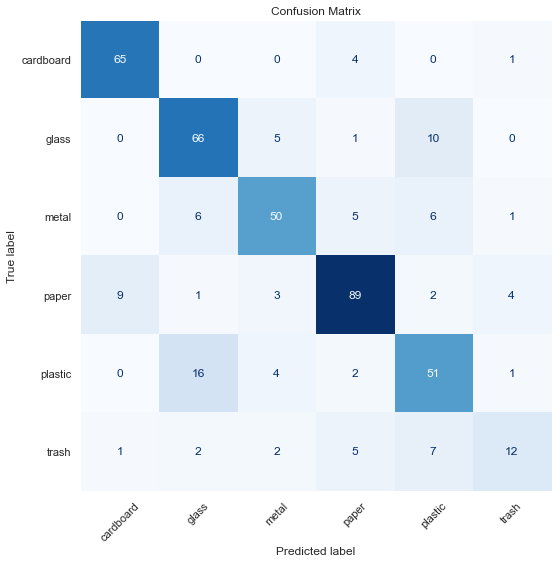

In [74]:
plot_confusion_matrix(model_V, test_iterator)

In [75]:
generate_confusion_matrix_and_classification_report(model_V, test_iterator)

1/1 [==============================] - 7s 7s/step
Label order: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Confusion Matrix:
 [[65  0  0  4  0  1]
 [ 0 66  5  1 10  0]
 [ 0  6 50  5  6  1]
 [ 9  1  3 89  2  4]
 [ 0 16  4  2 51  1]
 [ 1  2  2  5  7 12]]


In [76]:
# Save model performance
save_model_performance(name="MobileNet2",
                       test_acc=test_acc,
                       test_loss=test_loss,
                       train_params=train_params,
                       non_train_params=non_train_params,
                       model=model_V,
                       test_eval=test_eval)

* Validation accuracy improved by 24.08%.

* Validation loss decreased from 1.3351 to 0.6713.

* Indicates strong generalization and minimal overfitting.
* Test scores are in line with final validation scores — model shows excellent consistency.


# Model summary

In [77]:
data = {
    "Model Name": model_name,
    "Test Accuracy": test_acc,
    "Test Loss": test_loss,
    "Trainable Params": train_params,
    "Non-Trainable Params": non_train_params
}

df = pd.DataFrame(data)
df

,Model Name,Test Accuracy,Test Loss,Trainable Params,Non-Trainable Params
0,Simple neural network,0.429234,1.418381,74694,0
1,Neural network with dropout,0.378190,1.535137,74694,0
2,Neural network with normalization,0.250580,1.813645,75014,320
3,Neural network with regularizers,0.250580,1.834173,91846,320
4,MobileNet2,0.772622,0.671196,164742,2257984


* **Baseline model**:  Decent test accuracy (42.92%) and loss (1.418), lowest parameters count (74,694) — lightweight and fast.
* **Neural netorok with dropout**: Slight drop in accuracy (37.8%) — possibly under-regularized, same parameters count, but dropout may have limited learning capacity.
* **Neural network with normalization**: Lowest test accuracy (25.06%) despite slightly more parameters, signs of prediction collapse (biased toward one class), some non-trainable params added via normalization layer.
* **Neural network with regularizers**:  Same test accuracy as previous model (25.06%) but highest parameter count (91,846), despite added complexity and regularization, shows overfitting and no gain.
* **MobileNetV2**: Best performer by far: 77.26% test accuracy, 0.6712 test loss, uses ~2.4M non-trainable parameters, balanced performance and generalization across all classes.

### Model MobileNet2 will be considered in the further analysis.
- Despite being pre-trained, MobileNetV2 adapted well — maintaining high accuracy across train, validation and test sets.

- Validation accuracy reached 76.52%, closely aligned with the test accuracy of 77.26%, indicating the model avoids overfitting and generalizes well.

- Thanks to its depthwise separable convolutions, MobileNetV2 extracts rich, hierarchical features without bloating the model size.
- Although the non-trainable parameters are large, the trainable part is lightweight — enabling fast and cost-efficient fine-tuning.
- Top performer in nearly every class, especially cardboard, paper, and glass. The remaining classes, especially trash, can benefit from targeted improvements.

# New image class prediction

In [78]:
# Save the best model
model_V.save("./model/best_model.h5")

In [79]:
# Load the best model
model = load_model("./model/best_model.h5")

In [80]:
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Path to new images
folder = 'images'
extensions = ['*.jpg']
image_paths = []
for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(folder, ext)))

print(image_paths)

['images\\box.jpg', 'images\\can.jpg', 'images\\gl.jpg', 'images\\pla.jpg', 'images\\toi.jpg', 'images\\tra.jpg']



Processing: images\box.jpg
1/1 [==============================] - 2s 2s/step


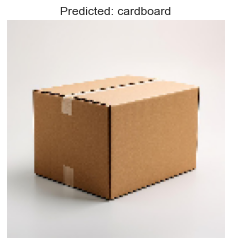

Prediction: cardboard

Processing: images\can.jpg
1/1 [==============================] - 0s 48ms/step


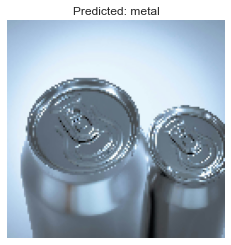

Prediction: metal

Processing: images\gl.jpg
1/1 [==============================] - 0s 52ms/step


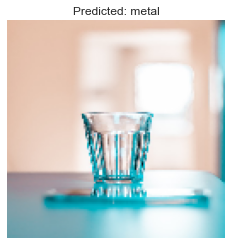

Prediction: metal

Processing: images\pla.jpg
1/1 [==============================] - 0s 57ms/step


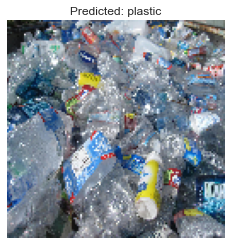

Prediction: plastic

Processing: images\toi.jpg
1/1 [==============================] - 0s 71ms/step


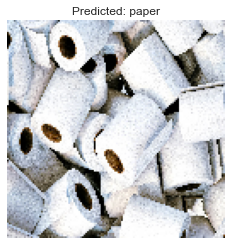

Prediction: paper

Processing: images\tra.jpg
1/1 [==============================] - 0s 67ms/step


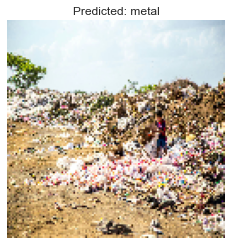

Prediction: metal


In [81]:
# New images class prediction 
for img_path in image_paths:
    print(f"\nProcessing: {img_path}")
    predicted_label = predict_image(model, img_path, class_labels)
    print(f"Prediction: {predicted_label}")